In [4]:
import csv
import pickle
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

In [5]:
def write_pickle(data, file_name):
    """Create a pickle file

    Keyword arguments:
    data -- the information to be saved
    file_name -- the name of the file without an extension
    """
    sys.setrecursionlimit(20000)
    pickle_file = open(file_name + '.pkl', 'wb')
    pickle.dump(data, pickle_file)
    pickle_file.close()
    sys.setrecursionlimit(3000)

    return True


def read_pickle(file_name):
    """Import a pickle file

    Keyword arguments:
    file_name -- the name of the file to be read without an extension
    """
    pickle_file = open(file_name + '.pkl', 'rb')
    file = pickle.load(pickle_file)
    pickle_file.close()

    return file


def write_csv(data, file_name):
    """Saves a flat dictionary to a .CSV.

    Keyword arguments:
    data -- a flat dictionary
    file_name -- the desired filename without an extension
    """
    with open(file_name + '.csv', 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in data:
            if type(row) == dict:
                csv_writer.writerow(list(row.values()))
            else:
                csv_writer.writerow(row)

    return True


def read_csv(file_name):
    """Reads a .CSV into a list.

    Keyword arguments:
    file_name -- the desired file to load without an extension
    """
    result = []
    with open(file_name + '.csv', newline='') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in csv_reader:
            result.append(row)

    return result


In [6]:
# Load and clean 2018 movies.
movies_2018 = pd.DataFrame(read_csv('data/2018_movies'))
movies_2018['datetime'] = pd.to_datetime(movies_2018[5] + ', 2018')
movies_2017 = pd.DataFrame(read_csv('data/2017_movies'))
movies_2017['datetime'] = pd.to_datetime(movies_2017[5] + ', 2017')
movies_2016 = pd.DataFrame(read_csv('data/2016_movies'))
movies_2016['datetime'] = pd.to_datetime(movies_2016[5] + ', 2016')
movies_2015 = pd.DataFrame(read_csv('data/2015_movies'))
movies_2015['datetime'] = pd.to_datetime(movies_2015[5] + ', 2015')
movies_2014 = pd.DataFrame(read_csv('data/2014_movies'))
movies_2014['datetime'] = pd.to_datetime(movies_2014[5] + ', 2014')
movies_2013 = pd.DataFrame(read_csv('data/2013_movies'))
movies_2013[5] = movies_2013[5].apply(
    lambda x: 'Feb 28' if x == 'Feb 29' else x)
movies_2013['datetime'] = pd.to_datetime(movies_2013[5] + ', 2013')
movies_2012 = pd.DataFrame(read_csv('data/2012_movies'))
movies_2012['datetime'] = pd.to_datetime(movies_2012[5] + ', 2012')
movies_2011 = pd.DataFrame(read_csv('data/2011_movies'))
movies_2011['datetime'] = pd.to_datetime(movies_2011[5] + ', 2011')
movies_2010 = pd.DataFrame(read_csv('data/2010_movies'))
movies_2010['datetime'] = pd.to_datetime(movies_2010[5] + ', 2010')

all_movies = pd.concat((movies_2018, movies_2017, movies_2016, movies_2015, movies_2014,
                        movies_2013, movies_2012, movies_2011, movies_2010))


def CountFrequency(my_list):
    freq = {}

    for item in my_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1

    return freq


# Filters distributors who have released more than 80 movies over the data set.
distributor_count = CountFrequency(all_movies[7])

# Manually select studios to reduce the number of featurs.
# dists = list({k: v for (k, v) in distributor_count.items() if (v > 80) and (k != '-')})
dists = ['Walt Disney Studios Motion Pictures', 'Universal Pictures', 'Twentieth Century Fox',
         'Sony Pictures Entertainment (SPE)', 'Paramount Pictures', 'Warner Bros.']

movie_set = all_movies.loc[all_movies[7].apply(
    lambda x: x in dists), [2, 3, 5, 7]]
movie_set.columns = ['Gross', 'Theaters', 'Date', 'Distributor']
movie_set['Gross'] = movie_set['Gross'].apply(
    lambda x: int(re.sub(r'[$,]', '', x)))
movie_set['Theaters'] = movie_set['Theaters'].apply(
    lambda x: x.replace('-', '0'))
movie_set['Theaters'] = movie_set['Theaters'].apply(
    lambda x: int(x.replace(',', '')))


In [7]:
# Creates flags for movie by distributor.
for distributor in dists:
    movie_set[distributor.replace(
        ' ', '')] = movie_set['Distributor'].apply(lambda x: 1 if x == distributor else 0)


In [8]:
movie_set.corr()


Gross  Theaters  \
Gross                            1.000000  0.511847   
Theaters                         0.511847  1.000000   
WaltDisneyStudiosMotionPictures  0.251333  0.147329   
UniversalPictures                0.032797  0.060323   
TwentiethCenturyFox             -0.023674  0.146139   
SonyPicturesEntertainment(SPE)  -0.055802 -0.040089   
ParamountPictures               -0.062603 -0.025142   
WarnerBros.                     -0.104844 -0.229831   

                                 WaltDisneyStudiosMotionPictures  \
Gross                                                   0.251333   
Theaters                                                0.147329   
WaltDisneyStudiosMotionPictures                         1.000000   
UniversalPictures                                      -0.165705   
TwentiethCenturyFox                                    -0.171409   
SonyPicturesEntertainment(SPE)                         -0.154058   
ParamountPictures                                      -0.149892   
WarnerBros.                                            -0.240924   

                                 UniversalPictures  TwentiethCenturyFox  \
Gross                                     0.032797            -0.023674   
Theaters                                  0.060323             0.146139   
WaltDisneyStudiosMotionPictures          -0.165705            -0.171409   
UniversalPictures                         1.000000            -0.191022   
TwentiethCenturyFox                      -0.191022             1.000000   
SonyPicturesEntertainment(SPE)           -0.171686            -0.177597   
ParamountPictures                        -0.167043            -0.172793   
WarnerBros.                              -0.268491            -0.277734   

                                 SonyPicturesEntertainment(SPE)  \
Gross                                                 -0.055802   
Theaters                                              -0.040089   
WaltDisneyStudiosMotionPictures                       -0.154058   
UniversalPictures                                     -0.171686   
TwentiethCenturyFox                                   -0.177597   
SonyPicturesEntertainment(SPE)                         1.000000   
ParamountPictures                                     -0.155302   
WarnerBros.                                           -0.249620   

                                 ParamountPictures  WarnerBros.  
Gross                                    -0.062603    -0.104844  
Theaters                                 -0.025142    -0.229831  
WaltDisneyStudiosMotionPictures          -0.149892    -0.240924  
UniversalPictures                        -0.167043    -0.268491  
TwentiethCenturyFox                      -0.172793    -0.277734  
SonyPicturesEntertainment(SPE)           -0.155302    -0.249620  
ParamountPictures                         1.000000    -0.242869  
WarnerBros.                              -0.242869     1.000000

(8.5, -0.5)

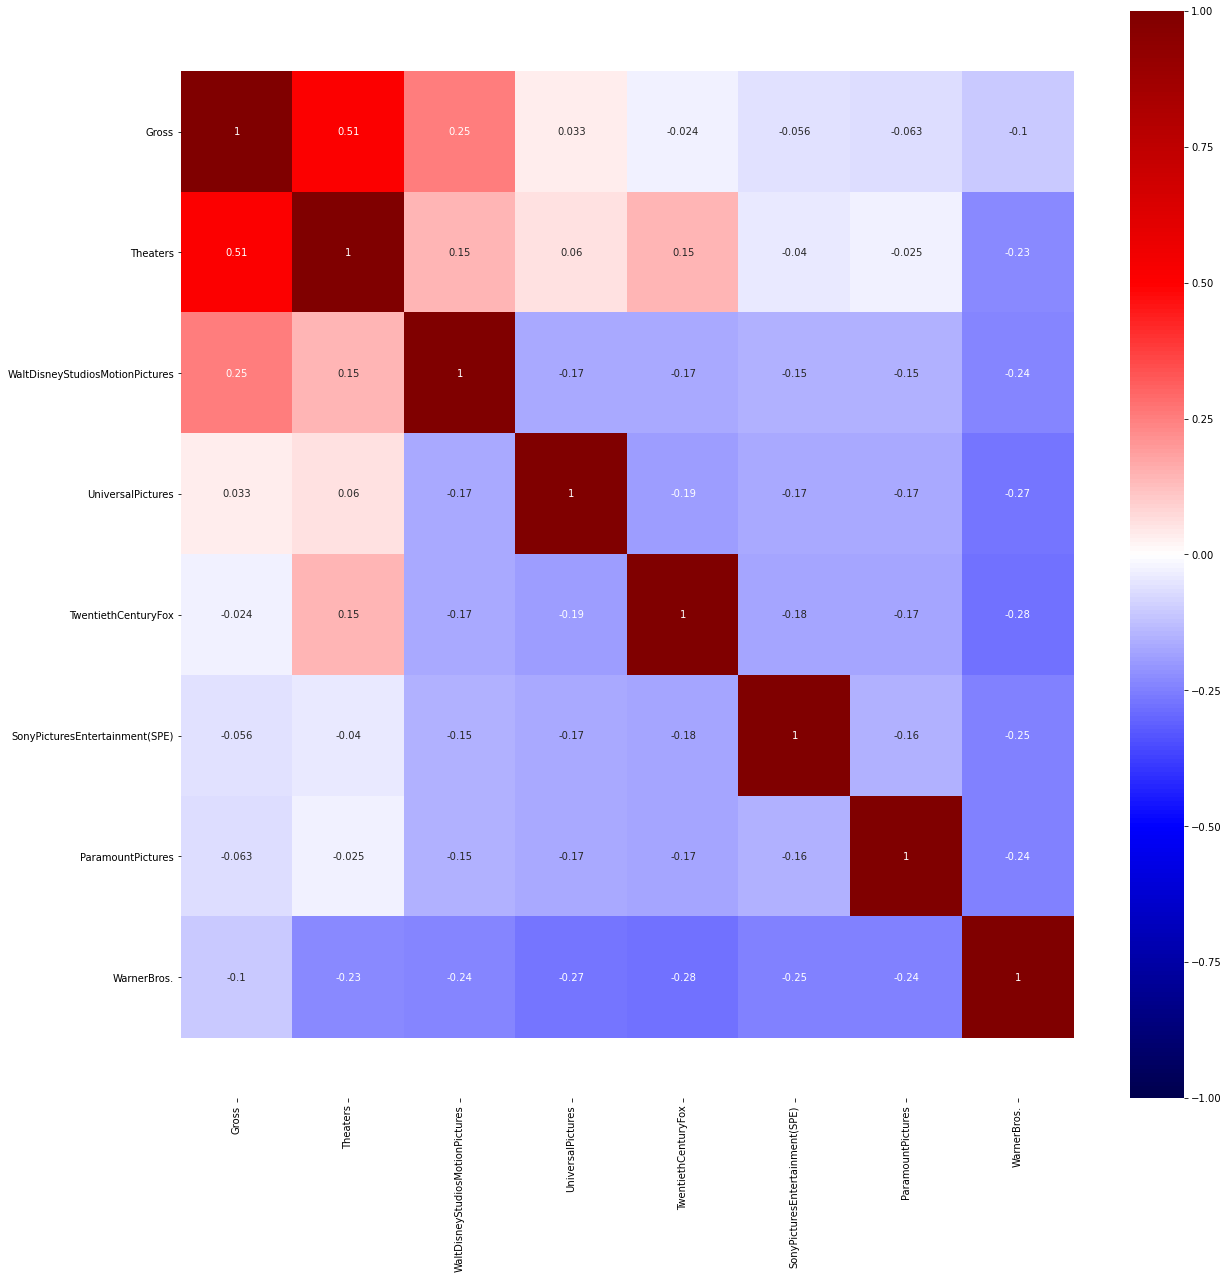

In [9]:
plt.figure(figsize=(20, 20))

sns.heatmap(movie_set.corr(),
            cmap="seismic", annot=True, vmin=-1, vmax=1)
plt.gca().set_ylim(len(movie_set.corr())+0.5, -0.5)

0.2619875741358223

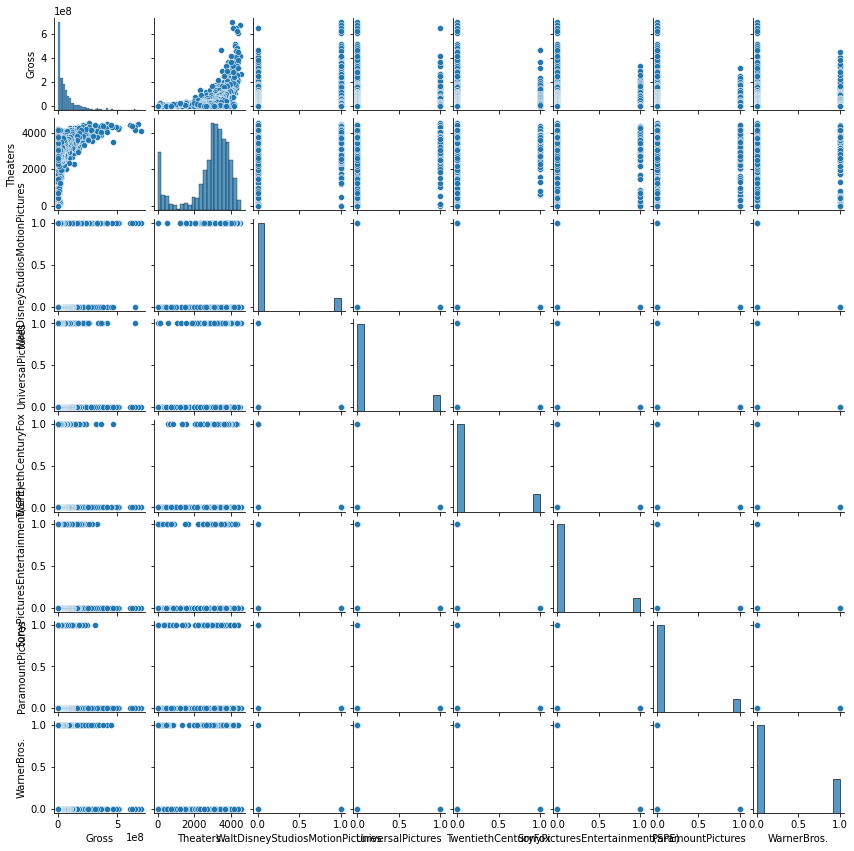

In [10]:
sns.pairplot(movie_set, height=1.5, aspect=1)
# %%
lr = LinearRegression()

X = movie_set['Theaters'].values.reshape(-1, 1)

y = movie_set['Gross']

lr.fit(X, y)
# %%
lr.score(X, y)
# %%
# Bucket directors, studios?, actors by earnings/salaries.
# Genres are not exclusive.

In [11]:
movie_for_full = movie_set.copy()

del movie_for_full['Date']
del movie_for_full['Distributor']

lr_full = LinearRegression()

X = movie_for_full.loc[:, 'Theaters':'WarnerBros.']

y = movie_for_full['Gross']

lr_full.fit(X, y)

lr_full.score(X, y)

0.3004982130731729

In [12]:
sm.add_constant(X).head()

const  Theaters  WaltDisneyStudiosMotionPictures  UniversalPictures  \
0    1.0      4084                                1                  0   
1    1.0      4474                                1                  0   
2    1.0      4410                                1                  0   
3    1.0      4485                                0                  1   
4    1.0      4349                                0                  0   

   TwentiethCenturyFox  SonyPicturesEntertainment(SPE)  ParamountPictures  \
0                    0                               0                  0   
1                    0                               0                  0   
2                    0                               0                  0   
3                    0                               0                  0   
4                    1                               0                  0   

   WarnerBros.  
0            0  
1            0  
2            0  
3            0  
4            0

In [13]:
model = sm.OLS(y, sm.add_constant(X))
fit = model.fit()
fit.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Gross   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     78.04
Date:                Sun, 04 Oct 2020   Prob (F-statistic):           3.50e-81
Time:                        20:00:49   Log-Likelihood:                -21490.
No. Observations:                1097   AIC:                         4.299e+04
Df Residuals:                    1090   BIC:                         4.303e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P&gt;|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -3.728e+07   5.62e+06     -6.629      0.000   -4.83e+07   -2.62e+07
Theaters                         3.974e+04   2098.781     18.937      0.000    3.56e+04    4.39e+04
WaltDisneyStudiosMotionPictures  3.595e+07   6.16e+06      5.839      0.000    2.39e+07     4.8e+07
UniversalPictures               -6.375e+06   5.57e+06     -1.144      0.253   -1.73e+07    4.56e+06
TwentiethCenturyFox             -2.721e+07   5.56e+06     -4.898      0.000   -3.81e+07   -1.63e+07
SonyPicturesEntertainment(SPE)  -1.528e+07   5.79e+06     -2.640      0.008   -2.66e+07   -3.92e+06
ParamountPictures               -1.893e+07   5.92e+06     -3.200      0.001   -3.05e+07   -7.32e+06
WarnerBros.                     -5.442e+06   4.31e+06     -1.263      0.207   -1.39e+07    3.01e+06
==============================================================================
Omnibus:                      604.796   Durbin-Watson:                   0.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5980.368
Skew:                           2.362   Prob(JB):                         0.00
Kurtosis:                      13.417   Cond. No.                     1.93e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.79e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
&quot;&quot;&quot;

Text(0, 0.5, &#39;Residuals&#39;)

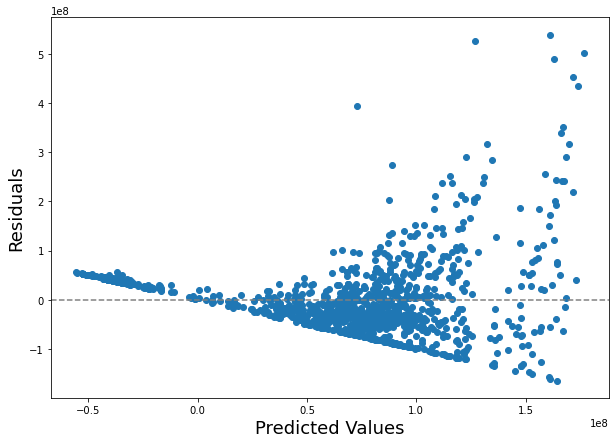

In [14]:
plt.figure(figsize=(10, 7))
plt.scatter(fit.predict(), fit.resid)

plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Predicted Values', fontsize=18)
plt.ylabel('Residuals', fontsize=18)

In [15]:
lr_full = LinearRegression()
X = movie_set[['Theaters', 'WaltDisneyStudiosMotionPictures', 'UniversalPictures',
               'TwentiethCenturyFox', 'SonyPicturesEntertainment(SPE)', 'ParamountPictures', 'WarnerBros.']]
y = movie_set['Gross']
lr_full.fit(X, y)
lr_full.score(X, y)

0.3004982130731729

In [16]:
p = PolynomialFeatures()
X_poly = p.fit_transform(X)

lr_full = LinearRegression()
lr_full.fit(X_poly, y)
lr_full.score(X_poly, y)

0.49432490171277377

In [17]:
X.shape

(1097, 7)

In [18]:
X_poly.shape

(1097, 36)